## Notes for next week:
* filter down json file
  * flatten the data
  * remove the retweets
  * save in format usable by nltk or scikit learn tools
* Scikit for text analysis 
* Answering the questions for exploration of data
* Decide an actual question to answer
  * Media and text in combination


1. How many are geo-tagged in syria
2. How many have pictures/videos?
3. Tweet dates, over what timeframe? 
4. Counts of distinct words in the text
5. Explore the hashtags used (can maybe confirm how they were scraped in the first place and/or find other tags)
6. Identify the most influential users/posts

In [239]:
import pandas
import json
import ijson
import pprint
from itertools import islice
import csv
from pandas.io.json import json_normalize
from pandas import ExcelWriter
import datetime
from collections import Counter
%matplotlib inline
import matplotlib.pyplot as plt

In [200]:
# set file path for tweets dataset
tweet_json_path = '/Users/adamstueckrath/Desktop/twitter_data/tweets/tweets.json'


In [201]:
# read n number of json objects from the tweets dataset
def read_n_from_file(json_path, n_lines):
    data = []
    with open(json_path) as f:
        for line in islice(f, n_lines):
            data.append(json.loads(line))
        return(data)  


In [202]:
# get sample json objects 
sample_json_objects = read_n_from_file(tweet_json_path, 1)
# print sample
print(sample_json_objects)


[{'_id': {'$oid': '595e82d713bbf01307babbba'}, 'created_at': {'$date': '2017-07-06T18:34:37.000Z'}, 'id': 8.830314454338519e+17, 'id_str': '883031445433851904', 'text': 'RT @rishibagree: Distance From Delhi to Syria - 3600 Km\nDistance From Delhi to #Basirhat WB-1100 km\n\nGuess where did @ndtv Reporters… ', 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'truncated': False, 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 94272634, 'id_str': '94272634', 'name': 'Oh my god!', 'screen_name': 'AnxJain', 'location': None, 'url': None, 'description': None, 'protected': False, 'verified': False, 'followers_count': 80, 'friends_count': 51, 'listed_count': 0, 'favourites_count': 6708, 'statuses_count': 4096, 'created_at': 'Thu Dec 03 06:37:58 +0000 2009', 'utc_offset': None, 'time_zone': None, 'geo_enabled': False, 'lang

# Data investigation
Functions to help investigate my data. Such as finding counts of the json file.

In [194]:
# %%timeit
# get the total number of json objects in file 
# json objects must be stored per line, not in an arrary 
# file contains separate JSON object on each line.
def count_json_objects(json_path):
    count = 0
    with open(json_path) as file:
        for line in file: 
            count+=1
        return count

def count_json_objects_chunk(json_path, chunk):
    count = 0
    with open(json_path) as f:
        while True:
            next_n_lines = list(islice(f, chunk))
            if not next_n_lines:
                break
            for line in next_n_lines: 
                count += 1
        return count


In [208]:
# print out the length of the json file
count_full_json = count_json_objects(tweet_json_path)
print('Total count of tweets {}'.format(count_full_json))

# how to profile a specific function
# %lprun -f count_json_objects count_json_objects(json_path)

Total count of tweets 2853841


## Main functions to investigate data
Since the file is over 15gbs and about ~3 million tweets, I need to create some function to help me parse the data.
* Created new-line deliminted json generator 
* Using `pandas.io.json import json_normalize` for nested objects 
* Identifying nested json datatypes 
* Flatting nested json for dataframes 

In [209]:
# new line json streamer
def nljson_generator(json_path):
    with open(json_path) as file:
        for line in file: 
            yield json.loads(line)
        
# load json to dataframe
def json_normalize_dataframe(json_object):
    dataframe = json_normalize(json_object)
    return dataframe

# get column names and types for nested json into dataframe
def normalize_dataframe_col_types(dataframe):
    column_details = {}
    columns = dataframe.columns.values.tolist()
    for column in columns: 
        column_details[column] = type(dataframe[column].iat[0])
    return column_details

# source code: https://towardsdatascience.com/flattening-json-objects-in-python-f5343c794b10
# flattens nested json
def flatten_json(json_object):
    out = {}
    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x
    flatten(json_object)
    return out


### Analysis in excel for better understanding of object structure 
* Problem: the json has a lot of information and I need to figure out what attribute I want to investigate (see printed object above)
* Solution: load n number of sample tweets to read and analysis into excel 

In [210]:
# create sample excel file with n number of tweets 
# read from json file, normalize json, and create dataframe
# transpose dataframe vertically, and save each tweet into seperate excel tab
def json_tweets_xlsx_sample(json_path, excel_path, 
                             tweet_start=0, tweet_limit='all', 
                             normalize=False):
    tweet_list = []
    json_stream = nljson_generator(json_path)
    
    if tweet_limit == 'all':
        tweets = json_stream
    else:
        if isinstance(tweet_limit, int): 
            tweets = islice(json_stream, tweet_start, tweet_start+tweet_limit)
    
    for tweet in tweets: 
        if normalize:
            tweet_normalize = json_normalize_dataframe(tweet)
            tweet_object = tweet_normalize.transpose()
        else:
            tweet_object = pandas.Series(tweet)
        tweet_list.append(tweet_object)
            
    print("writing tweets")
    writer = ExcelWriter(excel_path)
    for n, tweet in enumerate(tweet_list):
        tweet.to_excel(writer,'tweet%s' % n)
    writer.save()

# json_tweets_xlsx_sample(tweet_path, output_path, tweet_limit=10, normalize=True)
# json_tweets_xlsx_sample(tweet_path, output_path, tweet_start=100000, tweet_limit=15)


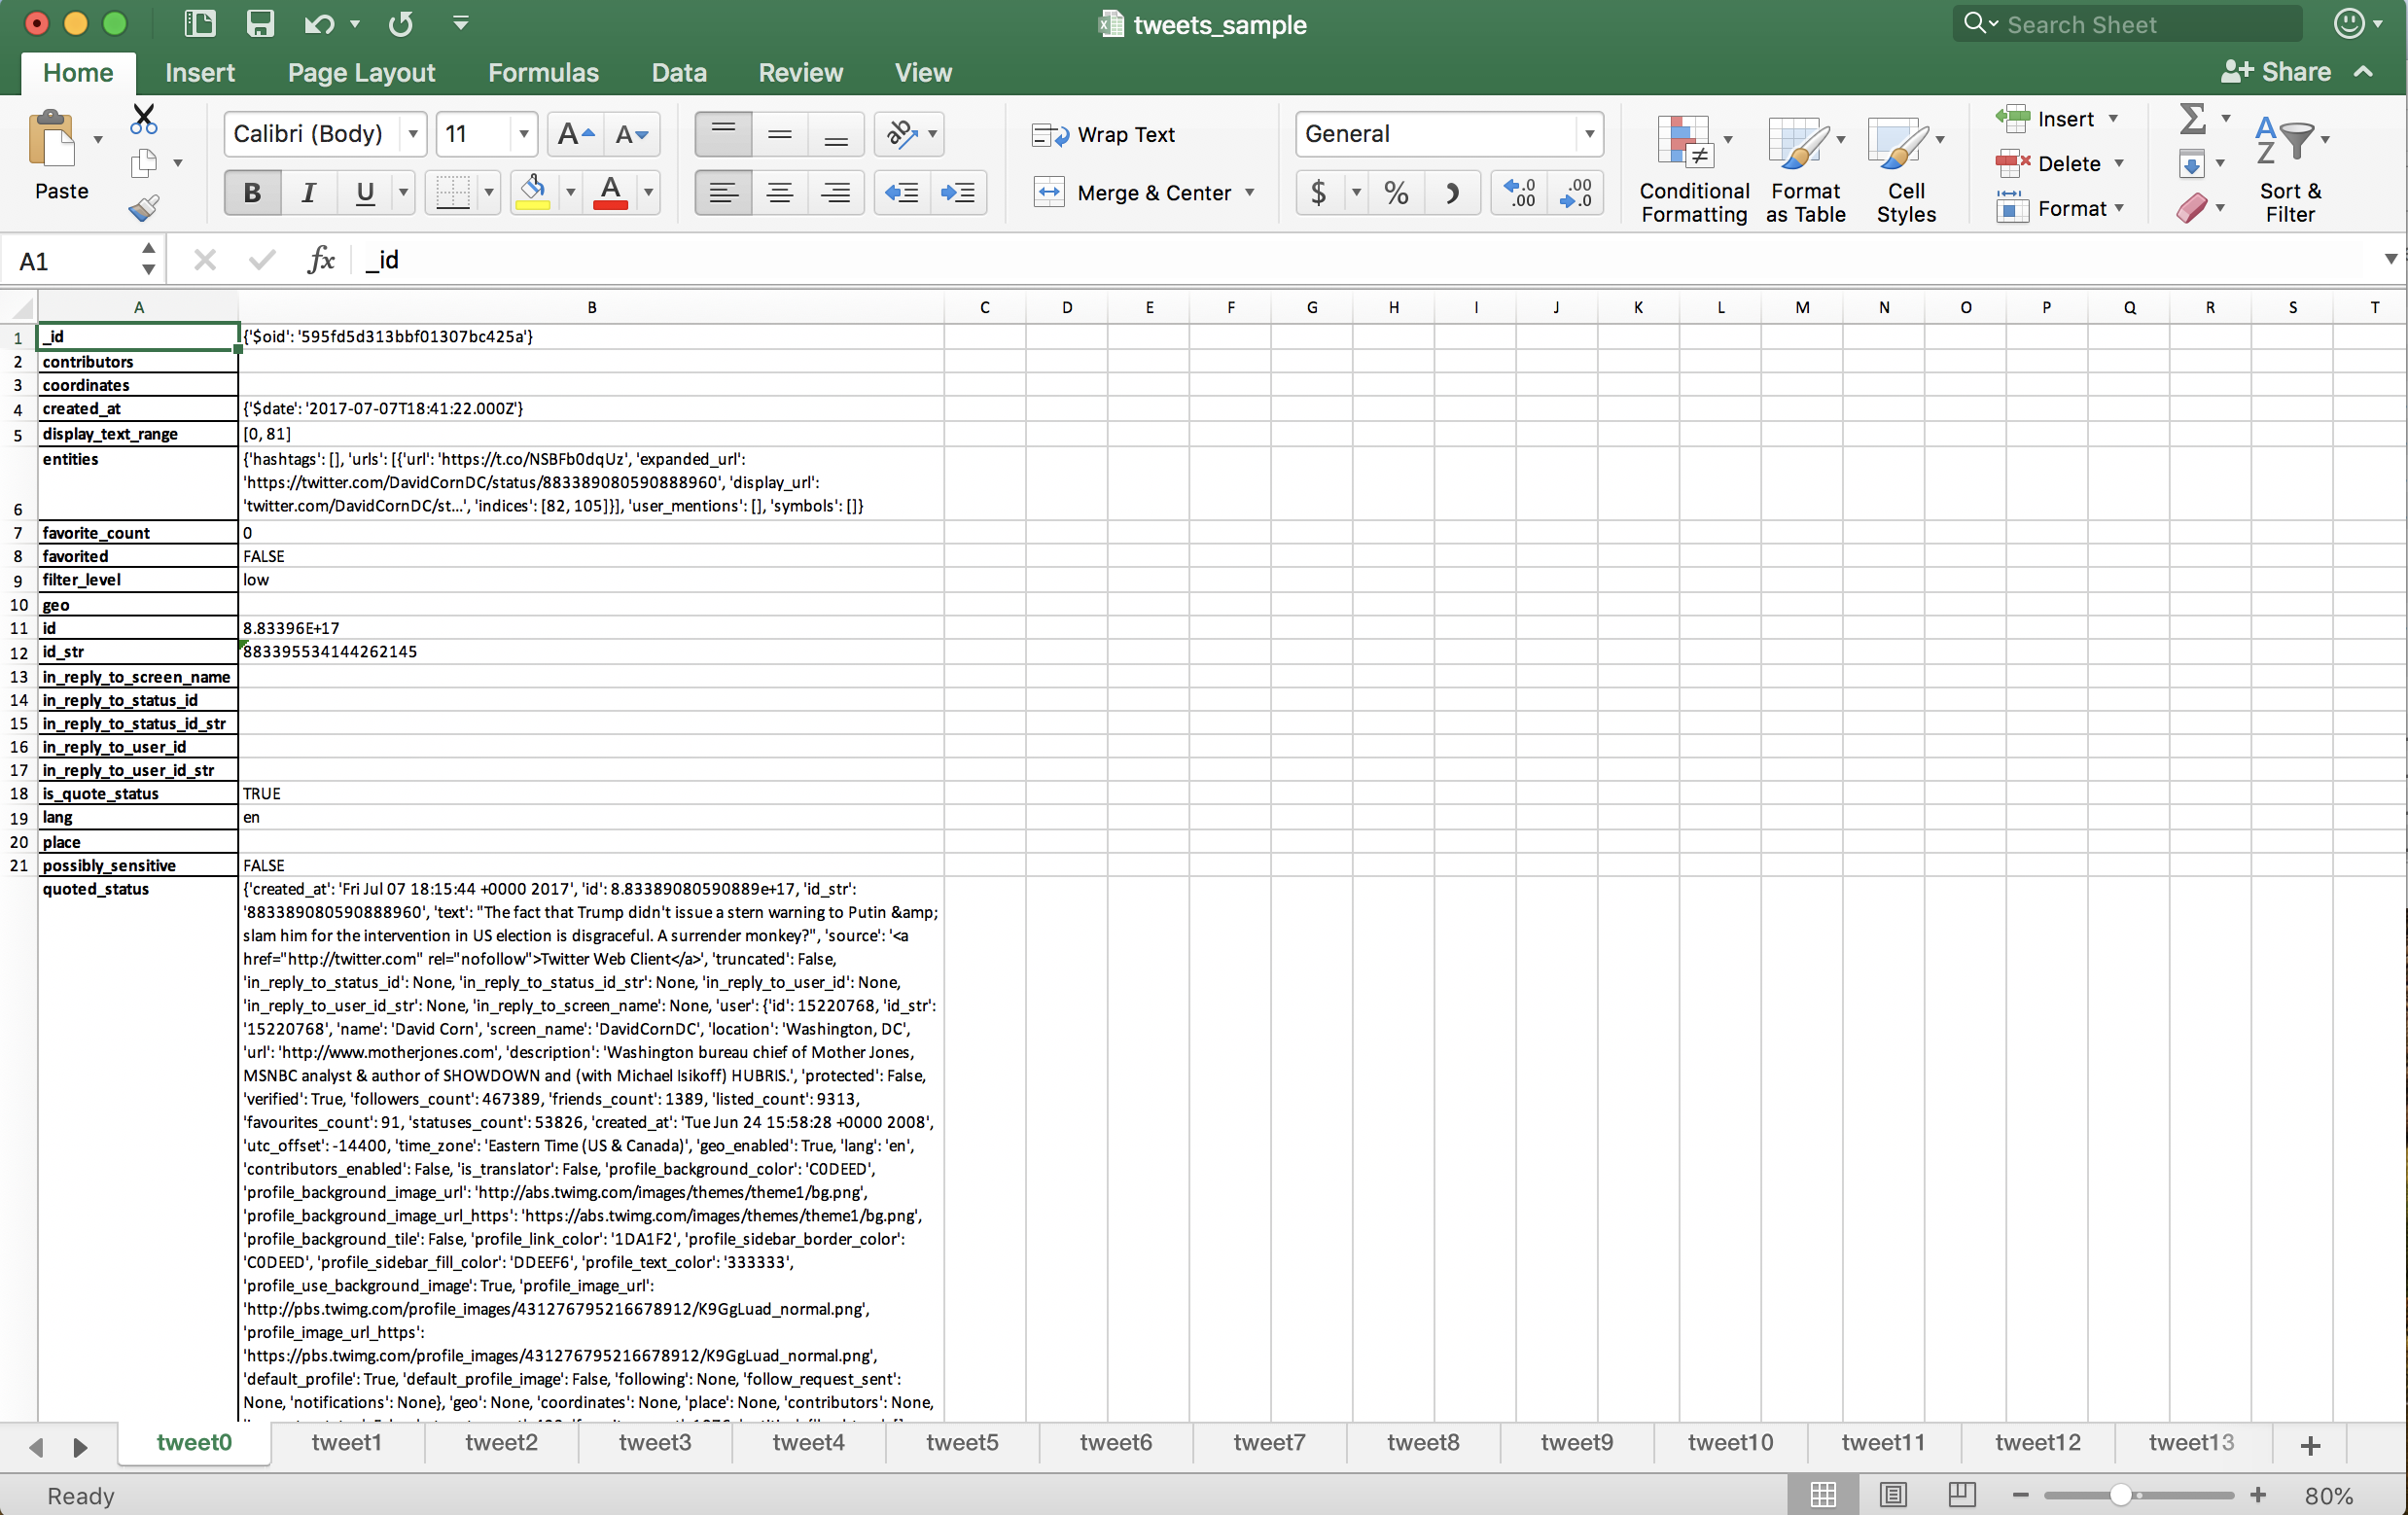



## Removing retweets
* I found that the majority of noise was from retweets. For example, if I flatten an original tweet there's only ~60 attributes. However, if I flatten a retweet there's about ~200 attributes. For my analysis, I want to concentrate my efforts on original and unique tweets. My assumption is that I can find more useful information from since they are coming from one source.

In [211]:
# removes retweets by checking the text of the tweet and if it starts with 'RT'
# writes original tweets to a new json file, line-delimited
def remove_retweets(json_path, output_json_path):
    json_stream = nljson_generator(json_path)
    with open(output_json_path, 'w', encoding='utf-8') as output:
        for tweet in json_stream:
            text = tweet['text']
            if text.startswith('RT'):
                continue
            else:
                json.dump(tweet, output)
                output.write("\n")
      

In [212]:
# remove retweets and get total count of the new file objects
tweets_no_retweets_path = '/Users/adamstueckrath/Desktop/twitter_data/tweets_no_retweets/tweets_no_retweets.json'
# remove_retweets(tweet_path, tweets_no_retweets_path)      

# print out the length of the new json file without retweets
count_no_retweets_json = count_json_objects(tweets_no_retweets_path)
print('Total count of tweets minus retweets: {}'.format(count_no_retweets_json))

Total count of tweets minus retweets: 1160088


In [220]:
# full json minus json with no retweets
print('Original file: {}\nNo retweets file: {}\nRemoved {} retweets'.format(count_full_json,
                                                                            count_no_retweets_json,
                                                                            (count_full_json-count_no_retweets_json)))

Original file: 2853841
No retweets file: 1160088
Removed 1693753 retweets


I will be using the no reweets json file for the rest of the investigation.

## How many are geo-tagged and where
* Identify how many tweets have location information
* Can I determine the location from their coordinates?

In [223]:
# how many are geo-tagged
# load latitude and longitude into dataframe
json_stream = nljson_generator(tweets_no_retweets_path)
geo_count = 0
geo_coordinates = []
for tweet in json_stream:  
    geo = tweet['geo']
    if geo:
        geo_count += 1
        geo_coordinates.append(geo['coordinates'])
    else:
        continue


In [224]:
# print the length of the geo counts
print(geo_count)

# create dataframe of geo coordinates
coordinates_df = pandas.DataFrame(geo_coordinates, columns=['lat', 'long'])
coordinates_df.head()


63396


,lat,long
0,31.3893,35.3612
1,31.3893,35.3612
2,33.4863,36.2988
3,31.3893,35.3612
4,31.3893,35.3612


In [231]:
print('Percentage of geo locaitons for dataset: {}'.format(round(geo_count/count_no_retweets_json, 3)))


Percentage of geo locaitons for dataset: 0.055


Interesting that there are only ~63,000 locations for tweets. That's a small number compared to +1 million unique tweets we have and less than 1 percent of the total tweets. 

In [232]:
# save geo location information to dataframe for future analysis
coordinates_df_path = '/Users/adamstueckrath/Desktop/twitter_data/tweets_no_retweets/tweets_no_retweets_geo.csv'
#coordinates_df.to_csv(coordinates_df_path)


## Get location information from coodinates
* Running into problems with this
* Qouta limits, ip bans, and api cost for querying maps
* Do not think this is even beneficail for analysis, but still fun and something new to learn

* Skipping this for now

* check out Zax's code with the sleep timer
* periodically write chunks to csv while iterating to not lose data when exceptions happen

In [233]:
# https://geopy.readthedocs.io/en/stable/#usage-with-pandas
import geopy.geocoders
from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import requests
geolocator = Nominatim(user_agent="nn")

# list_of_ints is used for printing the progress of geo location lookup
list_of_ints = [ x for x in range(0, 70000, 250) ]
def geo_search(row):
    if row.name in list_of_ints:
        print(row.name)
    try:
        location = geolocator.reverse(row.lat, row.long, language='en', timeout=1)
    except Exception as e:
        print(e)
        return None
    if location:
        try:
            location = location.raw
            address = location['address']
        except Exception as e:
            return None
    return address

# using google's api 
# need to pay for this
def reverse_geocode(row):
    if row.name in list_of_ints:
        print(row.name)
    result = {}
    url = 'https://maps.googleapis.com/maps/api/geocode/json?latlng={}'
    try:
        request = url.format(row.lat,row.long)
        data = requests.get(request).json()
        if len(data['results']) > 0:
            result = data['results'][0]
    except:
        print (row.lat,row.long)
        return result
    return result

# coordinates_df['address'] = coordinates_df.apply(lambda row: geo_search(row), axis=1)
# coordinates_df_path = '/Users/adamstueckrath/Desktop/twitter_data/tweets_no_retweets/tweets_no_retweets_geo.csv'
# coordinates_df.to_csv(coordinates_df_path)


## Collect tweet datetimes
* What's the timeframe for the tweets?
* Any outliers for year/months?

In [80]:
# get information about dates of tweets
# convert utc offset time
# save datetime information to csv file
# https://stackoverflow.com/questions/6217056/twitter-timezone-created-at-utc-time-values-to-calculate-what-time-zone-the
tweet_dates_csv = '/Users/adamstueckrath/Desktop/twitter_data/tweets_no_retweets/tweets_no_retweets_dates.csv'
json_stream = nljson_generator(tweets_no_retweets_path)
with open(tweet_dates, mode='w') as csv_file:
    tweet_writer = csv.writer(csv_file, delimiter=',')            
    for tweet in json_stream:
        tweet_id = tweet['_id']['$oid']
        tweet_date = tweet['user']['created_at']
        utc_offset = tweet['user']['utc_offset']
        tweet_date_object = pandas.to_datetime(tweet_date)
        tweet_date_object_offset = tweet_date_object.tz_localize(utc_offset)
        tweet_writer.writerow([tweet_id, tweet_date_object, tweet_date_object_offset])

In [234]:
# load tweet dates into dataframe from csv file
tweet_dates_df = pandas.read_csv(tweet_dates_csv, sep=',', delimiter=None, 
                                 header=None, names=['id','created_at','created_at_offset'],
                                 parse_dates=['created_at', 'created_at_offset'])
tweet_dates_df.head()


,id,created_at,created_at_offset
0,595e82d713bbf01307babbbd,2010-04-23 16:47:40,2010-04-23 19:47:40
1,595e82d713bbf01307babbc0,2017-03-03 07:35:57,2017-03-03 10:35:57
2,595e82d713bbf01307babbc1,2017-03-03 07:35:57,2017-03-03 10:35:57
3,595e82d713bbf01307babbc6,2016-11-10 21:59:10,2016-11-11 00:59:10
4,595e82d713bbf01307babbc7,2017-03-03 07:35:57,2017-03-03 10:35:57


### Plot tweet datetimes over time
Aggregate the datetimes to year, month, and day and then plot the counts

In [237]:
# remove time from created_at_offset and create new column
tweet_dates_df['created_at_offset_date'] = tweet_dates_df["created_at_offset"].apply(lambda tweet_date: 
                                                                                     datetime.datetime(year=tweet_date.year, 
                                                                                                       month=tweet_date.month, 
                                                                                                       day=tweet_date.day))
tweet_dates_df.head()


,id,created_at,created_at_offset,created_at_offset_date
0,595e82d713bbf01307babbbd,2010-04-23 16:47:40,2010-04-23 19:47:40,2010-04-23
1,595e82d713bbf01307babbc0,2017-03-03 07:35:57,2017-03-03 10:35:57,2017-03-03
2,595e82d713bbf01307babbc1,2017-03-03 07:35:57,2017-03-03 10:35:57,2017-03-03
3,595e82d713bbf01307babbc6,2016-11-10 21:59:10,2016-11-11 00:59:10,2016-11-11
4,595e82d713bbf01307babbc7,2017-03-03 07:35:57,2017-03-03 10:35:57,2017-03-03


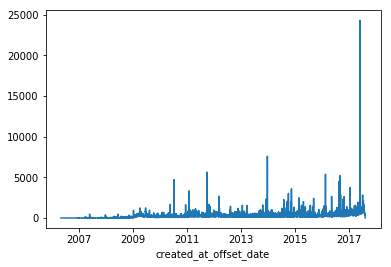

In [238]:
# group tweet dates and counts and plot over time
tweet_dates_group_df = tweet_dates_df['created_at_offset_date'].groupby([tweet_dates_df.created_at_offset_date.dt.date])\
                                                               .agg('count')
# plot the grouped dates
tweet_dates_group_df.plot(kind="line")

Probably want to remove any tweets before 2010/2011, which is the beginning of the protest and civil war

## Find unique hashtags and counts
* What are the top hashtags and their counts?
* Any surprises?

In [240]:
# find unique hashtags and counts 
# need to write a data cleaning function to clean the hashtag attribute
json_stream = nljson_generator(tweets_no_retweets_path)
tag_counter = Counter()
for tweet in json_stream:
    tweet_hashtags = tweet['entities']['hashtags']
    if tweet_hashtags:
        for hashtag in tweet_hashtags:
            text = hashtag['text'].lower()
            tag_counter[text] += 1      


In [243]:
# get top n hashtags
top_hashtags = tag_counter.most_common(25)

# make dataframe of top hashtags to chart
top_hashtags_df = pandas.DataFrame(top_hashtags,columns=['hashtag', 'hashtag_count'])

# print hashtag dataframe
top_hashtags_df.head()


,hashtag,hashtag_count
0,syria,122336
1,furkanpalalı,33751
2,no309,19158
3,iran,18323
4,raqqa,14342


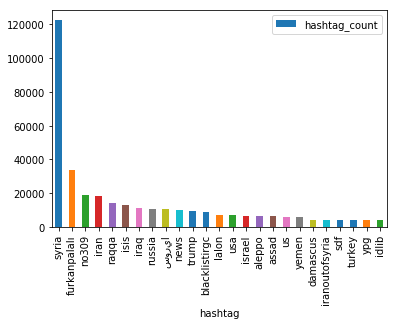

In [244]:
# plot the top n hashtags 
top_hashtags_df.plot.bar(x='hashtag', y='hashtag_count')


* Need to figure out how to translate arabic to english
  * Google translate is having problems in a lot of third party modules 
  * see: https://stackoverflow.com/questions/52455774/googletrans-stopped-working-with-error-nonetype-object-has-no-attribute-group
* How to determine if string is arabic or english? 
 ** If I use mtranslate will my ip get blocked?
* How important is translating?
* identify spaces, and maybe character types for the alphabet


In [343]:
# information about translating arabic
import mtranslate
t = 'جيش_اسود_الشرقية'
tt = 'Armyoftheeast'
#print(t.split())
test = mtranslate.translate(tt,"en","auto")
#print(mtranslate.translate))
print(test)

Armyoftheeast


## How many tweets have media?
* Get counts on the number of media and identify what they are (pictures, videos, news sites, etc.)
* Identify links that are actually videos - information is stored in the `extended_entities` field

In [269]:
# find media counts 
# need to write a data cleaning function to clean media types 
# and combine extended_entities and entities into one fiel
json_stream = nljson_generator(tweets_no_retweets_path)
media_counter = Counter()
for tweet in json_stream:
    # 'extended_entities' is for identifying videos/gifs
    # else everything is considered a picture in entities field
    if 'extended_entities' in tweet: 
        tweet_entities = tweet['extended_entities']
        tweet_media = tweet_entities['media'][0]
        media_counter[tweet_media['type']] += 1
    else:
        tweet_entities = tweet['entities']
        if tweet_entities['urls']:
            media_counter['link'] += 1
        elif 'media' in tweet['entities']:
            tweet_media = tweet_entities['media'][0]
            media_counter[tweet_media['type']] += 1
        else:
            media_counter['text'] += 1


In [315]:
# print the media counts
print(media_counter)


Counter({'link': 675073, 'text': 342069, 'photo': 128313, 'video': 12105, 'animated_gif': 2528})


In [311]:
# make dataframe of media types and counts to chart
tweet_media_df = pandas.DataFrame.from_dict(media_counter, orient='index')

# reset index on tweet_media_df dataframe
tweet_media_df.reset_index(inplace=True)

# rename columns on tweet_media_df dataframe
tweet_media_df.rename(columns={tweet_media_df.columns[0]:"media_type", 
                               tweet_media_df.columns[1]:"media_count"}, inplace=True)
# print media dataframe
tweet_media_df.head()


,media_type,media_count
0,text,342069
1,link,675073
2,video,12105
3,photo,128313
4,animated_gif,2528


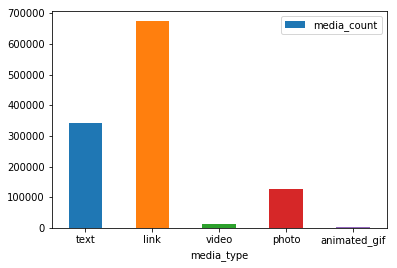

In [314]:
# chart the media types 
tweet_media_df.plot.bar(x='media_type', y='media_count', rot=0)


Enough information to work with media? I'm not sure.. I need to further investigate the link media 

## Identify the most influential users/posts

In [324]:
# check if user is verified and how many followers they have
json_stream = nljson_generator(tweets_no_retweets_path)
verified_followers_count = Counter()
for tweet in json_stream:
    if tweet['user']['verified']:
        verified_followers_count[tweet['user']['name']] = tweet['user']['followers_count']
    else:
        continue
    
print (verified_followers_count.most_common(25))

[('Cristiano Ronaldo', 55483337), ('CNN Breaking News', 51608570), ('The New York Times', 38776627), ('CNN', 36891841), ('Donald J. Trump', 33729315), ('BBC Breaking News', 33517358), ('The Economist', 21510139), ('BBC News (World)', 20664022), ('Reuters Top News', 18419472), ('Ricky Martin', 18195212), ('Fox News', 15499812), ('detikcom', 14561021), ('Wall Street Journal', 14467410), ('TIME', 14420490), ('Paulo Coelho', 12276381), ('ABC News', 11310917), ('The Associated Press', 11295386), ('Washington Post', 10798072), ('HuffPost', 10434463), ('Times of India', 10432845), ('METRO TV', 10183007), ('China Xinhua News', 10126515), ('NDTV', 9875729), ('WIRED', 9309063), ('United Nations', 9229338)]


In [325]:
# get top n verified users and follower count
verified_users_follower_count = verified_followers_count.most_common(25)

# make dataframe of influential users to chart
verified_users_followers_df = pandas.DataFrame(verified_users_follower_count,columns=['user', 'follower_count'])

# print influential users dataframe
verified_users_followers_df.head()


,user,follower_count
0,Cristiano Ronaldo,55483337
1,CNN Breaking News,51608570
2,The New York Times,38776627
3,CNN,36891841
4,Donald J. Trump,33729315


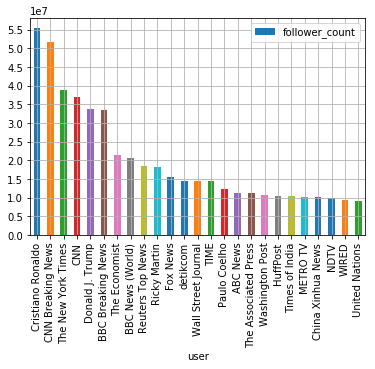

In [335]:
# plot the top n influential users 
verified_users_followers_df.plot.bar(x='user', y='follower_count', grid=True, yticks = range(0,60000000,5000000))




* Google machine learning api 
* is the new reporting leading of something happening? 
    ** the quality of journalist has gone done 
* sentiment in quality of post and indentify topics within sentiments 
* see a lot of hype and about a topic, how is the sentiment of the pictures attached? 
* How does 


* loop through data sources and scrape their profiles to bridge the gap between the last date and present 







## Data cleaning
Need to identify all important attributes for this project and list them below. This will be a part of the data cleaning/processing section.

For example:
* `id`: the unique identifier for the tweet
* `created_at`: when the tweet was sent
* `full_text`: the text included in the tweet
* `hashtags`: the hashtags (e.g. "#Syria" appears as "Syria") included in the tweet
* `urls`: the expanded version of urls included in the tweet (e.g. "https://t.co/ljRAxRICTr" is the shortened URL in the tweet and the full url is https://www.nytimes.com/reuters/2017/03/21/world/middleeast/21reuters-israel-syria-iran.html)
* `favorite_count`: number of times the tweet was favorited
* `retweet_count`: number of times the tweet was retweeted
* `source`: from what platform/app the tweet was posted

Main problem is that the data isn’t totally clean and I need to process it a little bit first. 